In [1]:
import numpy as np
import tensorflow as tf
import os
from google.colab import drive
import matplotlib.pyplot as plt
import datetime

In [2]:
#extracting dataset from google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Datasets/concrete_crack_images.zip

In [13]:
#configuring parameters
path = '/content/Data'

BATCH_SIZE = 32
IMG_SIZE = (200,200)
SEED = 20490

In [14]:
#train-val-test split
train_data = tf.keras.utils.image_dataset_from_directory(path, shuffle=True, 
                                            validation_split = 0.3, subset = 'training', 
                                            batch_size=BATCH_SIZE, 
                                            seed = SEED,
                                            image_size=IMG_SIZE)
val_data = tf.keras.utils.image_dataset_from_directory(path, shuffle=True, 
                                            validation_split = 0.3, subset = 'validation', 
                                            batch_size=BATCH_SIZE, 
                                            seed = SEED,
                                            image_size=IMG_SIZE)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Found 40000 files belonging to 2 classes.
Using 12000 files for validation.


In [15]:
val_batches = tf.data.experimental.cardinality(val_data)
test_dataset = val_data.take(val_batches // 5)
validation_dataset = val_data.skip(val_batches // 5)

In [16]:
#pre-fetch the datasets
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_pf = train_data.prefetch(buffer_size=AUTOTUNE)
validation_dataset_pf = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset_pf = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [20]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [21]:
class_names = train_data.class_names
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

In [23]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x,training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 200, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

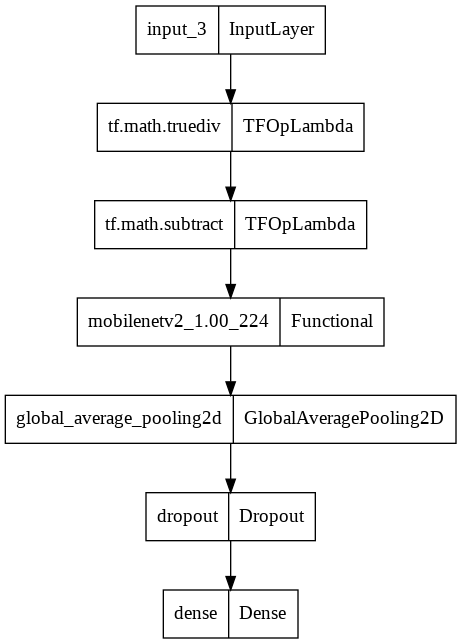

In [24]:
tf.keras.utils.plot_model(model)

In [25]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
EPOCHS = 10

log_path = r"/content/logs" + datetime.datetime.now().strftime("%Y%M%d-%H%M%S") 
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2)

history = model.fit(train_dataset_pf, validation_data=validation_dataset_pf, epochs=EPOCHS, callbacks=[tb_callback,es_callback])

Epoch 1/10
875/875 [==============================] - 914s 1s/step - loss: 0.1107 - accuracy: 0.9643 - val_loss: 0.0226 - val_accuracy: 0.9952
Epoch 2/10
875/875 [==============================] - 893s 1s/step - loss: 0.0196 - accuracy: 0.9954 - val_loss: 0.0139 - val_accuracy: 0.9965
Epoch 3/10
875/875 [==============================] - 855s 977ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.0107 - val_accuracy: 0.9969
Epoch 4/10
875/875 [==============================] - 858s 981ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0089 - val_accuracy: 0.9969
Epoch 5/10
875/875 [==============================] - 842s 962ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.0080 - val_accuracy: 0.9972
Epoch 6/10
875/875 [==============================] - 858s 981ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.0073 - val_accuracy: 0.9974
Epoch 7/10
875/875 [==============================] - 901s 1s/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0071 - val_accu

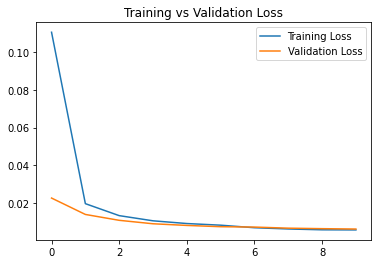

<Figure size 432x288 with 0 Axes>

In [27]:
#graphing model loss and accuracy over the training
training_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch

plt.plot(epoch, training_loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.figure()
plt.show()

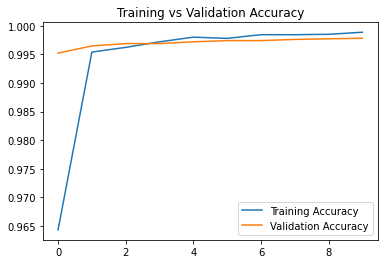

<Figure size 432x288 with 0 Axes>

In [28]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epoch, train_acc, label='Training Accuracy')
plt.plot(epoch, val_acc, label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

In [29]:
test_loss, test_accuracy = model.evaluate(test_dataset_pf)
print(f'Loss = {test_loss}')
print(f'Accuracy = {test_accuracy}')

75/75 [==============================] - 57s 751ms/step - loss: 0.0096 - accuracy: 0.9971
Loss = 0.00959698110818863
Accuracy = 0.997083306312561


In [30]:
#make predictions
image_batch, label_batch = test_dataset_pf.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions,axis=1)

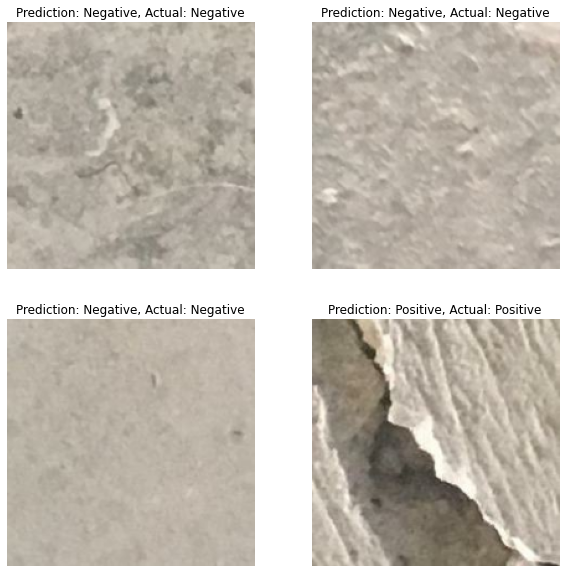

In [31]:
#show some predictions
plt.figure(figsize=(10,10))

for i in range(4):
    axs = plt.subplot(2,2,i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    current_prediction = class_names[class_predictions[i]]
    current_label = class_names[label_batch[i]]
    plt.title(f"Prediction: {current_prediction}, Actual: {current_label}")
    plt.axis('off')
    
save_path = r"/content"
plt.savefig(os.path.join(save_path,"result.png"),bbox_inches='tight')
plt.show()